# Content-based recommender system using Movielens dataset

Notebook to illustrate basics of content-based recommendation.  We build a recommender matrix of all users ratings (rows) vs movie film titles (columns) and then use a correlation function to identify similar films to a couple of examples (*Star Wars* and *LiarLiar*)


Movielens user data set (u.data) obtained from http://files.grouplens.org/datasets/movielens/ml-100k.zip

We are using the 100,000 user ratings database.  The above zip file contains other files including the README with more info about the data.

From the README we can see the following:

The u.data file contains the full data set of 100,000 ratings by 943 users on 1682 items.

 - Each user has rated at least 20 movies.  

 - Users and items are numbered consecutively from 1.  

 - The data is randomly ordered. 

 - This is a tab separated list of user id | item id | rating | timestamp. 

 - The time stamps are unix seconds since 1/1/1970 UTC.
 
The Movie_Id_Titles contains movie titles

 - There are 1683 rows (mvie titles).

 - Row 1 contains headers 'item_id', 'title'
 
 - Rows 2 to 1683 contain the titles


## 1) Import libraries

In [477]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2) Get data

Let's have at the user data file in our text editor...

In [478]:
# ! subl u.data

The u.data file has no column headings.  We know from the README what these are so let's create them as a list for use in reading the data in...

In [479]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

Let's read the data in together with column headings and taking into account that we know it is a tab separated file...

In [480]:
df = pd.read_csv('u.data',sep='\t',names=column_names) 
# sep cannot infer '\t' from files so explicitly supply arg
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
user_id      100003 non-null int64
item_id      100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [481]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [482]:
! subl Movie_Id_Titles # 1682 titles

Let's read the data in using defaults. Headers will be inferred.  Sep will be inferred...

In [483]:
movie_titles=pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


It will be easier to work with this stuff if everything's in one df.  The attribute *item\_id* is common to both so we can merge on that.  Before we do this Let's just check that there are no duplicates of item_id in either data set....

In [484]:
len(df.item_id.unique()) 

1682

df contains 1682 unique *item\_id* values, as expected: 1 *item\_id* per film.

In [485]:
len(movie_titles.item_id.unique())

1682

movie_titles contains 1682 unique *item\_id* values.  Let's check for cases where a film exists twice (same film is refrenced by 2 different ids)...

In [486]:
len(movie_titles.title.unique())

1664

Ah. Some of the films are duplicated in the movie_titles df!  Let's see which films are duplicated in the movie_titles database...

In [487]:
movie_titles[movie_titles.title.duplicated(keep=False)].sort_values(by='title')

,item_id,title
669,670,Body Snatchers (1993)
572,573,Body Snatchers (1993)
1649,1650,"Butcher Boy, The (1998)"
1644,1645,"Butcher Boy, The (1998)"
1233,1234,Chairman of the Board (1998)
1653,1654,Chairman of the Board (1998)
245,246,Chasing Amy (1997)
267,268,Chasing Amy (1997)
1605,1606,Deceiver (1997)
308,309,Deceiver (1997)


We need to bear this in mind in case it become an issue for our classifier...

We'll now go ahead with our merge based on item_id...

In [488]:
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [489]:
df.tail()

,user_id,item_id,rating,timestamp,title
99998,840,1674,4,891211682,Mamma Roma (1962)
99999,655,1640,3,888474646,"Eighth Day, The (1996)"
100000,655,1637,3,888984255,Girls Town (1996)
100001,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."
100002,655,1641,3,887427810,Dadetown (1995)


Let's check no null data...

In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
user_id      100003 non-null int64
item_id      100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
title        100003 non-null object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


Let's have a look at one of our films that was linked to 2 different IDs...

In [491]:
print(df[df.title=="Body Snatchers (1993)"])

       user_id  item_id  rating  timestamp                  title
73131       38      573       1  892433660  Body Snatchers (1993)
73132      312      573       5  891712535  Body Snatchers (1993)
73133       95      573       1  888954808  Body Snatchers (1993)
73134      339      573       3  891036016  Body Snatchers (1993)
73135      254      573       2  886475476  Body Snatchers (1993)
73136       11      573       3  891906327  Body Snatchers (1993)
73137      366      573       5  888858078  Body Snatchers (1993)
73138      380      573       1  885480737  Body Snatchers (1993)
73139      405      573       3  885548435  Body Snatchers (1993)
73140      406      573       3  880132319  Body Snatchers (1993)
73141      653      573       1  880152843  Body Snatchers (1993)
73142      375      573       4  886622131  Body Snatchers (1993)
73143      537      573       2  886031886  Body Snatchers (1993)
73144      425      573       3  878738914  Body Snatchers (1993)
73145     

We see that this film shows up with IDs of 573 and also 670.

Now that our data is merged, we can use _title_ to specify films, so the *item\_id* column is effectively redundant so, it looks like this is not a problem for our recommender 



Let's look at our user df again...

In [492]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


As we see from the above, at the moment each film is listed multiple times - one row for each user that gave it a review. It would be good to have a database which has one row for each film and a mean rating for that film.

We can do this by grouping by title and then getting a mean rating...

In [493]:
df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                                   2.333333
1-900 (1994)                                                2.600000
101 Dalmatians (1996)                                       2.908257
12 Angry Men (1957)                                         4.344000
187 (1997)                                                  3.024390
2 Days in the Valley (1996)                                 3.225806
20,000 Leagues Under the Sea (1954)                         3.500000
2001: A Space Odyssey (1968)                                3.969112
3 Ninjas: High Noon At Mega Mountain (1998)                 1.000000
39 Steps, The (1935)                                        4.050847
8 1/2 (1963)                                                3.815789
8 Heads in a Duffel Bag (1997)                              3.250000
8 Seconds (1994)                                            3.750000
A Chef in Love (1996)                                       4.125000
Above the Rim (1994)        

The above gives us the films in order of title (what we grouped by). We might prefer to have these ordered by descending mean rating in which case... 

In [494]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

We should note that some of the highly rated films may have only one review!

    i.e .... **ratings != popularity**
   

Instead of groupby with _.mean()_, we can use groupby with _.count()_ to look at films with the largest numbers of ratings...

In [495]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

## 3) Data preparation

First lets revisit our title + rating data we viewed above and recreate it in a separate dataframe giving films and average ratings...

In [496]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Let's be clear that our rating is an average and relabel the column heading...

In [497]:
ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_df.head(3)

,average_rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257


Now let's look at a way of addressing our observation that some reviews have less value due to very few reviewers.  We can create a new _num of ratings_ column in our *ratings\_df*.  

We will add *number of ratings* data from our original df by using groupby on title again, but this time use *.count()* instead of *.mean()* ...

In [498]:
ratings_df['num_of_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_df.head()

,average_rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


## 4) Data exploration

Let's use the ratings df we have created to see a distribution of how many ratings a film typically has...

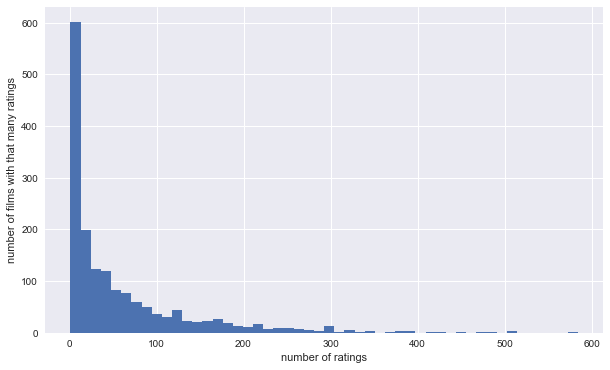

In [499]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

So we see a long tailed distribution skewed to high numbers of ratings (think 'Star Wars').  Most movies have few ratings. 

Now let's look at the distribution of film ratings...

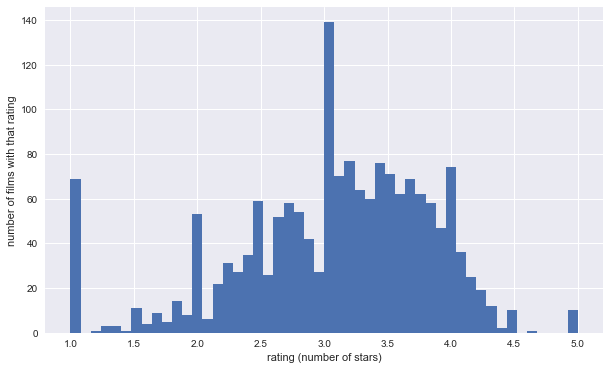

In [500]:
plt.figure(figsize=[10,6])
ratings_df.average_rating.hist(bins=50)
plt.xlabel('rating (number of stars)')
plt.ylabel('number of films with that rating')

This is interesting - the film rating data looks _sort of_ normally distributed but with spikes at integer values.

Why would we get high numbers of integer values?  These will be the films that have got just one review (and these films form the majority of our dataset!).

Once films have more than one rating, we calculate an average and therefore we (probably) no longer have a whole number.  

So we having been thinking about two things:

    i)  average rating a film has
    ii) the number of ratings

What is the relationship betweeen these two measures?  Let's use a jointplot to see what sot of correlation there is if any...

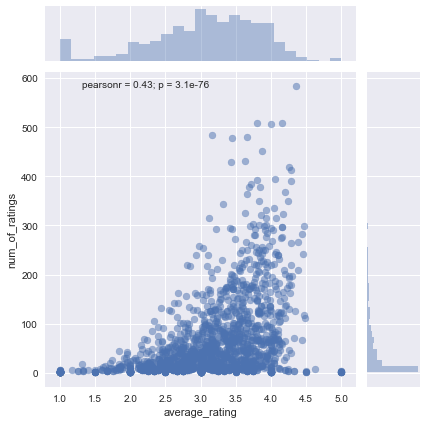

In [503]:
sns.jointplot(x='average_rating',y='num_of_ratings', data=ratings_df, alpha=0.5)

From the above, it looks like films with more ratings correlate to films with higher average ratings.  
This makes sense, because more people will inevitably be drawn to watching those films that have higher ratings and people will tend to avoid films that ratings suggest are bad.

## 5) Create recommender

We want to build a recomendation system based on item similarity (content-based recommender).

Let's create matrix with user ids on one axis and ratings on another (a bit like like an X matrix of examples and features).

Let's review our original df again...

In [504]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [505]:
len(df.groupby(by='title')['rating'].count())

1664

We can convert _df_ into the equivalent of an X matrix using *.pivot_table()*...

In [506]:
user_movie_matrix = df.pivot_table(values='rating' , index='user_id' , columns='title' )
user_movie_matrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note: Lots of missing values - because most people have not seen most of the movies.
We have created a sparse matrix.   

Let's use our *ratings_df* dataframe and look at the films with the highest numbers of ratings...

In [507]:
ratings_df.sort_values(by='num_of_ratings', ascending=False).head()

,average_rating,num_of_ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


Let's focus on ratings from all individual users for a couple of the popular movies listed above.  We'll get individual ratings for user from our other df - moviematrix.  

We'll look at Star Wars and Liar, Liar and grab the ratings for all users...

In [508]:
starwars_user_ratings = user_movie_matrix['Star Wars (1977)']
liarliar_user_ratings = user_movie_matrix['Liar Liar (1997)']

In [509]:
starwars_user_ratings.head(15)

user_id
0     5.0
1     5.0
2     5.0
3     NaN
4     5.0
5     4.0
6     4.0
7     5.0
8     5.0
9     5.0
10    5.0
11    NaN
12    4.0
13    5.0
14    5.0
Name: Star Wars (1977), dtype: float64

In [510]:
liarliar_user_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

So we can basically create a profile for each movie based on how the entirety of users rated it.

What's more interesting is that we can look at the correlation between 2 such series.

pandas has 2 corr methods:
- ._corr()_    *pairwise correlation of columns in a df*
- ._corrwith()_   *pairwise correlation between rows or columns of **two DataFrame objects** *

We can use _.corrwith()_ to get correlation between 2 pandas series.

Remember that a column of a df is a Series...

In [511]:
type(user_movie_matrix), type(user_movie_matrix['12 Angry Men (1957)' ])

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [219]:
starwars_user_ratings.head(3)

user_id
0    5.0
1    5.0
2    5.0
Name: Star Wars (1977), dtype: float64

In [575]:
similar_to_starwars = user_movie_matrix.corrwith(starwars_user_ratings)
similar_to_starwars.head()

# Here we get a series which shows how each of the other movies correlate to Star Wars,
# This corr data is produced from the cols for each film which contain individual usder ratings

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

The above line of code generates a series which shows how each of the other movies correlate to Star Wars.  

The correlation value between 'Star Wars' and 'Til There Was You (1997)' is 0.872872.  This value is  generated by comparing all of the 943 users' scores for Star Wars with all of the 943 users' scores for 'Til There Was You (1997)'.  

We can do the same thing between 'Star Wars' and every other film in the dataset. Each comparison between 2 films results in 1 corr coeff.  So there should be a correlation coefficient with each film.  There are 1664 films so there should be 1664 correlation coefficients (including self correlation).

In [523]:
np.shape(similar_to_starwars)

(1664,)

The corr data is produced by comparing our series (Star Wars all 943 user ratings) with each column from the moviematrix.

Here is a miniature _moviematrix_:


User ID   |    Star wars    | 2001-Space Odyssey |  Endless Love
----------|-----------------|--------------------|----------------
  alice   |        5        |          5         |        0
   bob    |        3        |          2         |        5
  carol   |        5        |          5         |        1
   dai    |        5        |          4         |        2
  ellie   |        1        |          2         |        5

Users 2 and 5 are romantics
Users 1 and 3 like sci-fi
User 4 likes exciting films

Star Wars 1 and 2001: Space Odyssey are higly correlated
Endless Love is almost inversely correlated to the other 2

We have 3 film. Our "correlation-with-Star_wars" series will therefore have 3 elements, one for each of the other 2 films and also a self-correlation score of 1. 

In [529]:
similar_to_liarliar = user_movie_matrix.corrwith(liarliar_user_ratings)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Let's do some tidying up here.  We'll create a dataframe to use rather than a series...

In [535]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])

In [540]:
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
3 Ninjas: High Noon At Mega Mountain (1998),NaN


In [539]:
corr_starwars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 'Til There Was You (1997) to Á köldum klaka (Cold Fever) (1994)
Data columns (total 1 columns):
Correlation    1410 non-null float64
dtypes: float64(1)
memory usage: 26.0+ KB


From _.info()_ we can see we have lots of null values (example case being a film which has got a rating by only 1 user and that user has not reviewed Star Wars and vice versa.)  

Let's drop the null values...

In [543]:
corr_starwars.dropna(inplace=True)
corr_starwars.head(10)

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


We can put our similar films in descending order of correlation, so we can see better 'matches'...

In [544]:
corr_starwars.sort_values(by='Correlation', ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


 So this looks like it contains some useful but it may also contain results based on films that have very few reviews.
 eg User 'Joe Bloggs' has watched Star Wars and given it 5 stars then also watched a film that no-one else has seen and also given it 5 stars.

It might make sense to exclude films with less than a certain number of ratings.  Let's review tthe histogram of number of ratings...

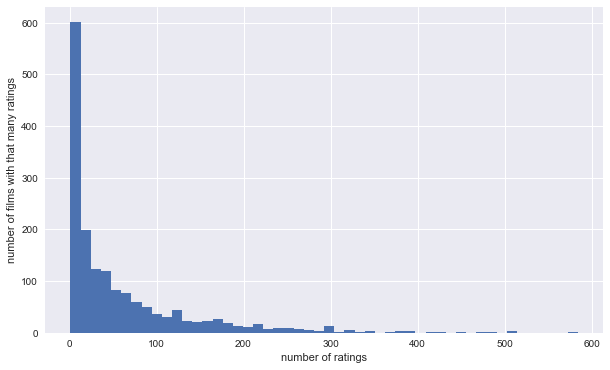

In [545]:
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

From looking at the above plot, we might want to focus on films with more than 50 reviews.  First let's add a column to our Star Wars correlation df to show number of ratings...

In [549]:
corr_starwars = corr_starwars.join(ratings_df['num_of_ratings'])
corr_starwars.head()

# Note that it's easy to use join here instead of merge because we have title as index which makes join a good fit

,Correlation,num_of_ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now let's filter out films with 50 reviews or less...

In [550]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 50]

In [551]:
new_corr_starwars.head(10)

,Correlation,num_of_ratings
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2 Days in the Valley (1996),0.066654,93
"20,000 Leagues Under the Sea (1954)",0.289768,72
2001: A Space Odyssey (1968),0.230884,259
"39 Steps, The (1935)",0.106453,59
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151
Ace Ventura: Pet Detective (1994),0.062689,103


Let's put this into descending order so we can get a better appreciation of how well our recommender is working...

In [556]:
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
"Life Less Ordinary, A (1997)",0.411638,53
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331


It looks like our recommender is mostly suggesting blockbusters, which is permhaps not surprising. Perhaps a better test would be a film that was less of a blockbuster and appeled to more specific tastes.

Perhaps we might also want to increase our number of ratings filter since Shadowlands (78 ratings) and Giant (51 ratings) seem unexpectedly high....

new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 50]

In [560]:
new_corr_starwars = corr_starwars[corr_starwars['num_of_ratings'] > 200]
new_corr_starwars.sort_values('Correlation',ascending=False).head(20)

,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
L.A. Confidential (1997),0.319065,297
E.T. the Extra-Terrestrial (1982),0.303619,300
Batman (1989),0.289344,201


We want to be able to use our recommender with other films so let's create a function...

In [606]:
def recommender(film_x, min_num_reviews):
    # Get user ratings for film
    film_x_user_ratings = user_movie_matrix[film_x]
    # Create pandas series of correlations for all films with film_x
    similar_to_film_x = user_movie_matrix.corrwith(film_x_user_ratings)
    # Convert to df
    corr_film_x = pd.DataFrame(similar_to_film_x, columns=['Correlation'])
    # Drop nulls
    corr_film_x.dropna(inplace=True)
    # Join ratings info to enbale filtering of films with low nums of ratings
    corr_film_x = corr_film_x.join(ratings_df['num_of_ratings'])
    # Apply filter
    new_corr_film_x = corr_film_x[corr_film_x['num_of_ratings'] >= min_num_reviews]
    # Sort intp ascending order
    return new_corr_film_x.sort_values('Correlation',ascending=False).head(20)

Test the function...

In [608]:
recommender('Star Wars (1977)', 50)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,num_of_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Giant (1956),0.488093,51
"Life Less Ordinary, A (1997)",0.411638,53
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331


Let's look at 'Liar Liar (1997)'...

In [610]:
recommender('Liar Liar (1997)', 50)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,num_of_ratings
title,,
Liar Liar (1997),1.000000,485
Casper (1995),0.538816,52
Batman & Robin (1997),0.532858,62
Batman Forever (1995),0.516968,114
Bean (1997),0.504689,91
Flubber (1997),0.494258,53
Dumb & Dumber (1994),0.494006,69
"Mask, The (1994)",0.484650,129
"Island of Dr. Moreau, The (1996)",0.477731,57


The above is not bad for the first 5 -10 recommendations.

Now let's try a few of quite specific films...

In [611]:
recommender('12 Angry Men (1957)', 50)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,num_of_ratings
title,,
12 Angry Men (1957),1.000000,125
Addicted to Love (1997),0.867722,54
Last Man Standing (1996),0.657596,53
Akira (1988),0.651377,50
Bob Roberts (1992),0.624499,85
Ulee's Gold (1997),0.619544,184
Menace II Society (1993),0.615203,50
McHale's Navy (1997),0.612372,69
Rear Window (1954),0.570513,209


In [613]:
recommender('Clerks (1994)', 50)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,num_of_ratings
title,,
Clerks (1994),1.000000,148
Forbidden Planet (1956),0.670241,67
Excess Baggage (1997),0.645497,52
I Know What You Did Last Summer (1997),0.643809,100
Heavy Metal (1981),0.631165,73
Things to Do in Denver when You're Dead (1995),0.576836,71
"Magnificent Seven, The (1954)",0.572713,121
"American Werewolf in London, An (1981)",0.571524,99
"Brothers McMullen, The (1995)",0.571100,73


In [614]:
recommender('Shine (1996)', 50)

/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/fluff/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,Correlation,num_of_ratings
title,,
Shine (1996),1.000000,129
Desperate Measures (1998),0.904534,72
Anastasia (1997),0.853389,66
"American in Paris, An (1951)",0.717511,50
Hercules (1997),0.691902,66
"Fox and the Hound, The (1981)",0.674120,61
Jaws 2 (1978),0.655071,66
Daylight (1996),0.646221,57
"Quiet Man, The (1952)",0.626870,67
